# Support Vector Machine (SVM)

SVM是一個常用的演算法，他的核心概念是找到Data set裡的 support vectors。

假設在Linear seperable 的data set裡面找到一條可以區分data的線，理論上我們可以找到無數條線符合我們要求，那我們要選哪一條呢？根據SVM的核心概念，我們應該找邊界最大的(large margin)的線，這邊的邊界(margin)指的是最靠近分隔線的點到分隔線的距離，SVM就是找到距離最大的那條線。如下圖(此圖來源為台大林軒田老師的講義：Machine Learning Techniques : L201)，$X_{1}-X_{2}-1=0$這條線就是SVM所找到的最大邊界的線，而那些在落在邊界上的點，就是所謂的Support Vectors。

SVM的優點是，他對於雜訊的容忍度比較高，就算data point有fluctuation，因為Large Margin的關係，預測的結果也不容易受到影響。

<img src="svm.png" width="300" height="300" align="center"/>

### support vector machine (SVM) : learn fattest hyperplanes(with help of support vectors )

因為我們這邊會直接call sklearn的package，所以這裡不會特別把求SVM的過程寫下來(我也有點懶惰)，不過簡單講一下概念就是用向量投影的方式去計算邊界，然後會有一些不等式的條件要滿足，這時候就用lagrange multiplier，然後再用微分解出K.K.T conditions，詳細證明可以去看林軒田老師的投影片，寫得很詳細。下方的$Z_{n}$是將$X_{n}$做座標轉換，在SVM中可以用Kernel來決定要將X轉換到什麼座標平面。


$$min_{b,w,\epsilon} \ (1/2)*W^{T}W + C*\Sigma_{n=1}^{N}\epsilon_{n}$$
s.t $$y_{n}(W^{T}Z_{n}+b)\geq 1-\epsilon_{n} \ and \ \epsilon_{n}>0 \ for \ all \ n$$


### C is aparameter that trade-off large margin and margin violation. 


$\epsilon_{n}$是用來計算margin violation，如果C越大，得出來的 w的margin violation就會越小，而margin也會越小，而C越小，margin就會越大，但是margin violation也會越大。

### 我們這邊一樣直接應用SVM在我們的data上，但是這次的data比較特別，總共有10個labels (0~9)，2個features，我們要使用1 vs. all method，試著用SVM將其中一個label和其他data分開：

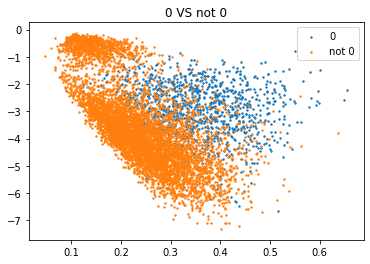

In [7]:
import numpy as np
from numpy.linalg import matrix_power
import numpy.linalg 
from sklearn import svm
from matplotlib import pyplot as plt
import math

log_C = [-3,-2,-1,0,1]
w = []

X_train = np.genfromtxt("/Users/huangyuchen/Desktop/ML_NTU/features.train.txt")
X_test = np.genfromtxt("/Users/huangyuchen/Desktop/ML_NTU/features.test.txt")

X_tr = X_train[:,1:]
y_tr = X_train[:,0]
X_te = X_test[:,1:]
y_te = X_test[:,0]

plt.scatter(X_tr[y_tr == 0][:, 0], X_tr[y_tr == 0][:, 1], s = 2, label='0')
plt.scatter(X_tr[y_tr != 0][:, 0], X_tr[y_tr != 0][:, 1], s = 2, label='not 0')

plt.title('0 VS not 0')
plt.legend()

### 這裡使用的是linear kernel，$K(x_{n},x_{m}) = x_{n}^{T}x_{m}^{T}$，其實就是不作任何轉換。
### 由下圖我們可以看到，髓著C變大，$W^{T}W$會跟著變大，同時margin會跟著變小。

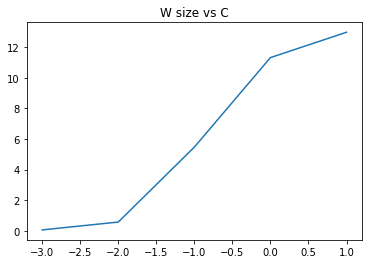

In [8]:
y_tr_0 = (y_tr == 0).astype('int')
y_te_0 = (y_te == 0).astype('int')
ein = []
for i in log_C:
    ## apply linear kernel##
    clfdig = svm.SVC(kernel='linear', C = 10**i)
    g_svm_poly_dig = clfdig.fit(X_tr,y_tr_0)
    e = np.mean(clfdig.predict(X_tr)!=y_tr_0)
    ein.append(e)
    w_svm = clfdig.coef_
    w_norm = np.linalg.norm(w_svm)
    w.append(w_norm)
    
plt.plot(log_C,w)
plt.title('W size vs C')
plt.show()

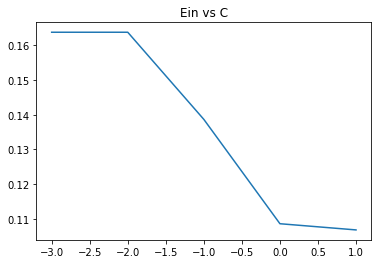

In [9]:
plt.plot(log_C,ein)
plt.title('Ein vs C')
plt.show()

### 這裡使用的是polynomial kernel，$K(x_{n},x_{m}) = (1 + x_{n}^{T}x_{m}^{T})^{Q}$ 。這裡使用 Q = 2，將 X 轉換到二次多項式的空間。

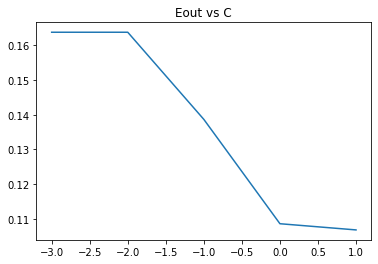

In [10]:
eout = []
for i in log_C:
    ## apply poly kernel##
    clfdig = svm.SVC(kernel='poly',degree = 2, coef0 =1,gamma =1, C = 10**i)
    g_svm_poly_dig = clfdig.fit(X_tr,y_tr_0)
    ## use svm.SVC predict Eout##
    e = np.mean(clfdig.predict(X_te)!=y_te_0)
    eout.append(e)
    
plt.plot(log_C,ein)
plt.title('Eout vs C')
plt.show()

### 這裡使用的是Radius basis function kernel，$K(x_{n},x_{m}) = exp(-\gamma ||x_{n} - x_{m}||^{2})$ ，這裡是將X轉換到無限多為的空間。並試著找到最佳的C和   $\gamma$

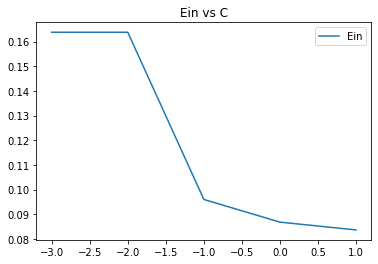

In [31]:
log_C = [-3,-2,-1,0,1]
ein = []
eout = []
for i in log_C:
    ## apply rbf kernel##
    clfdig = svm.SVC(kernel='rbf', gamma =100, C = 10**i)
    g_svm_poly_dig = clfdig.fit(X_tr,y_tr_0)
    ## use svm.SVC predict Ein##
    ei = np.mean(clfdig.predict(X_tr)!=y_tr_0)
    eout.append(np.mean(clfdig.predict(X_te)!=y_te_0))
    ein.append(ei)
    
plt.plot(log_C,ein)
plt.title('Ein vs C')
plt.legend(['Ein'])
plt.show()

### 從上圖我們試著透過觀察$E_{in}$來調整$\gamma$和C，來找到最小的$E_{out}$，所以這裡選擇 C = 10。但是從下圖可以發現，$E_{in}$最小的$\gamma$，反而會得到最大的$E_{out}$，也就是很可能有overfitting的發生，所以這裡再次證明，一昧地降低$E_{in}$並不能真正的得到最好的$E_{out}$。

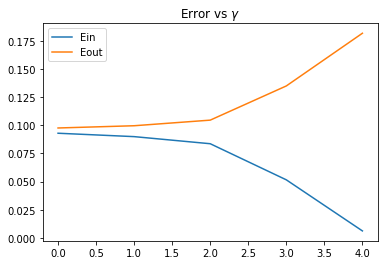

In [28]:
log_ga = [0,1,2,3,4]
ein = []
eout = []
for i in log_ga:
    ## apply rbf kernel##
    clfdig = svm.SVC(kernel='rbf', gamma =10**i, C = 10)
    g_svm_poly_dig = clfdig.fit(X_tr,y_tr_0)
    ## use svm.SVC predict Ein##
    ei = np.mean(clfdig.predict(X_tr)!=y_tr_0)
    ## use svm.SVC predict Eout##
    eou = np.mean(clfdig.predict(X_te)!=y_te_0)
    ein.append(ei)
    eout.append(eou)
    
plt.plot(log_ga,ein)
plt.plot(log_ga,eout)
plt.title('Error vs $\gamma$')
plt.legend(['Ein','Eout'])
plt.show()